<a href="https://colab.research.google.com/github/abolfazlsamadi/Classification-model-detect-pneumonia/blob/main/Classification_model_detect_pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Classification model detect pneumonia**

*   List item
*   List item




In this file, we are going to create a model that can diagnose pneumonic disease and divide the input photos into two groups, patient and non-patient.

i'm going to use "Chest X-Ray Images (Pneumonia)" dataset.
you can download it from the below link.

[chest-xray-pneumonia](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)

## In the first step, we shoud load the dataset.

---
**If you use colab, follow the instructions below :**


*   install "kaggle" lib
*   upload the "kaggle.json" file.
*   move it in ".kaggle" dir.
*   and change mode to "600"

*   then download the dataset.



In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:51<00:00, 68.6MB/s]
100% 2.29G/2.29G [00:51<00:00, 47.9MB/s]


# The next step, we should unzip the dataset

In [4]:
import os
import zipfile

path_zip = "chest-xray-pneumonia.zip"
zip_file = zipfile.ZipFile(path_zip,'r')
zip_file.extractall("data")
zip_file.close()

# import Required libraries

In [5]:
import numpy as np
import pandas as pd
import shutil

In [ ]:
base_dir = "data/chest_xray"

train_dir = os.path.join(base_dir,"train")
train_dir_normal = os.path.join(train_dir,"NORMAL")
train_dir_pneumonia = os.path.join(train_dir,"PNEUMONIA")

test_dir = os.path.join(base_dir,"test")
test_dir_normal = os.path.join(test_dir,"NORMAL")
test_dir_pneumonia = os.path.join(test_dir,"PNEUMONIA")

val_dir = os.path.join(base_dir,"val")
val_dir_normal = os.path.join(val_dir,"NORMAL")
val_dir_pneumonia = os.path.join(val_dir,"PNEUMONIA")


print(f'there are {len(os.listdir(train_dir_normal))+len(os.listdir(train_dir_pneumonia))} images for training. \n')
print(f'there are {len(os.listdir(test_dir_normal))+len(os.listdir(test_dir_pneumonia))} images for testing. \n')
print(f'there are {len(os.listdir(val_dir_normal))+len(os.listdir(val_dir_pneumonia))} images for validation. \n')

I think validation data is too small so move some data from train data to validation data.

In [7]:
split_size = 0.12

train_normal_size = len(os.listdir(train_dir_normal))
train_pneumonia_size = len(os.listdir(train_dir_pneumonia))

split_normal_size = int(split_size * train_normal_size)
split_pneumonia_size = int(split_size * train_pneumonia_size)

#print(split_normal_size,split_pneumonia_size)

train_normal_list = os.listdir(train_dir_normal)
train_pneumonia_list = os.listdir(train_dir_pneumonia)

normal_list_for_move = np.random.choice(train_normal_list, split_normal_size, replace=False)
pneumonia_list_for_move = np.random.choice(train_pneumonia_list, split_pneumonia_size, replace=False)

print("the size of normal validation data before moving files is : " , len(os.listdir(val_dir_normal)))
print("the size of pneumonia validation data before moving files is : " , len(os.listdir(val_dir_pneumonia)))


for img in normal_list_for_move:
  shutil.move(train_dir_normal+'/'+img, val_dir_normal+'/'+img)

for img in pneumonia_list_for_move:
  shutil.move(train_dir_pneumonia+'/'+img, val_dir_pneumonia+'/'+img)


print("the size of normal validation data after moving files is : " , len(os.listdir(val_dir_normal)))
print("the size of pneumonia validation data after moving files is : " , len(os.listdir(val_dir_pneumonia)))

the size of normal validation data before moving files is :  8
the size of pneumonia validation data before moving files is :  8
the size of normal validation data after moving files is :  168
the size of pneumonia validation data after moving files is :  473


In [8]:
print(f'there are {len(os.listdir(train_dir_normal))+len(os.listdir(train_dir_pneumonia))} images for training. \n')
print(f'there are {len(os.listdir(test_dir_normal))+len(os.listdir(test_dir_pneumonia))} images for testing. \n')
print(f'there are {len(os.listdir(val_dir_normal))+len(os.listdir(val_dir_pneumonia))} images for validation. \n')

there are 4591 images for training. 

there are 624 images for testing. 

there are 641 images for validation. 



we will use pre-trained models, so in this point we should download weights.

In [9]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [10]:
#!wget --no-check-certificate \
#    https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#    -O /tmp/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-10-07 19:32:08--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  29.7MB/s    in 2.8s    

2021-10-07 19:32:11 (29.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [11]:
#from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3


#pre_trained_model = VGG16(input_shape = (150, 150, 3), 
#                                include_top = False, 
#                                weights = None)

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)


#weights_file = "/tmp/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

weights_file = "/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

pre_trained_model.load_weights(weights_file)

for layer in pre_trained_model.layers :
  layer.trainable = False


#pre_trained_model.summary()

#last_layer = pre_trained_model.get_layer("block5_conv3")
last_layer = pre_trained_model.get_layer("mixed7")
last_output = last_layer.output

In [12]:
from tensorflow.keras.optimizers import RMSprop


x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1,activation="sigmoid")(x)


model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

# Data preprocessing

**At this point, we need to pre-process our data**

normalize the data & data augmentation & labeling

**import Required libraries**

In [13]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255. ,
                                   rotation_range = 20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 10,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))

val_generator = train_datagen.flow_from_directory(val_dir,
                                                  batch_size = 10,
                                                  class_mode = 'binary', 
                                                  target_size = (150, 150))

Found 4591 images belonging to 2 classes.
Found 641 images belonging to 2 classes.


In [15]:
class my_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy')>=0.97):
            print('Reached 97% accuracy so cancelling training!')
            self.model.stop_training= True 

callbacks = my_callback()

In [16]:
history = model.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 1,
            callbacks =[callbacks])

Epoch 1/20
100/100 [==============================] - 60s 283ms/step - loss: 0.4117 - accuracy: 0.8510 - val_loss: 0.2000 - val_accuracy: 0.9200
Epoch 2/20
100/100 [==============================] - 27s 274ms/step - loss: 0.2735 - accuracy: 0.9020 - val_loss: 0.1935 - val_accuracy: 0.9260
Epoch 3/20
100/100 [==============================] - 27s 274ms/step - loss: 0.2142 - accuracy: 0.9120 - val_loss: 0.2425 - val_accuracy: 0.9220
Epoch 4/20
100/100 [==============================] - 27s 267ms/step - loss: 0.2301 - accuracy: 0.9190 - val_loss: 0.1992 - val_accuracy: 0.9380
Epoch 5/20
100/100 [==============================] - 27s 269ms/step - loss: 0.2211 - accuracy: 0.9370 - val_loss: 0.5511 - val_accuracy: 0.8340
Epoch 6/20
100/100 [==============================] - 27s 269ms/step - loss: 0.2426 - accuracy: 0.9150 - val_loss: 0.1875 - val_accuracy: 0.9380
Epoch 7/20
100/100 [==============================] - 27s 273ms/step - loss: 0.2335 - accuracy: 0.9263 - val_loss: 0.1427 - val_ac

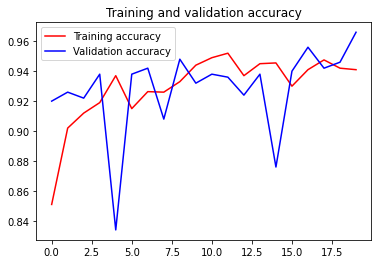

<Figure size 432x288 with 0 Axes>

In [17]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()